In [2]:
import sys; sys.path.append("..") 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import loadfile, savefile, exists
from src.dataprocessing import *
from src import rnn

## load data

In [3]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [4]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(f"{continuous_path}/cts_{min_len}/dataset {min_len}_{i}.csv"):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv', print_msg=False)
    cts_list.append(cts_df)
    i += 1

In [5]:
update = False

# Future = 10

In [6]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 10
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta = 1.5
att_type = 'exp'
factor = rnn.super_attention(delta, future_size, future_num, att_type)
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers = 1
num_neurons = 40
dense_layers = 2
dense_neurons = 20
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,2)]
i=0
for iteration in iteration_list:
    for model_type in model_list: 
        model_num = iteration
        model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
        result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
        result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
        time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
        result = pd.concat([result, time_steps], axis=1)
        result['iteration'] = iteration
        result['num_layers'] = num_layers
        result['num_neurons'] = num_neurons
        result['model_type'] = model_type
        if not i:
            result_reshape = result
        else:
            result_reshape = pd.concat([result_reshape, result], axis=0)
        i += 1

In [8]:
result_reshape[(result_reshape['step']=='mean')].sort_values(by='R2_MEAN', ascending=False)

,R2_TT-3061-3,R2_TT-3061-5,R2_LT-3061-2,R2_MEAN,NRMSE_TT-3061-3,NRMSE_TT-3061-5,NRMSE_LT-3061-2,NRMSE_MEAN,step,iteration,num_layers,num_neurons,model_type
10,0.643773,0.774076,0.882981,0.766944,8.767684,8.163619,5.170053,7.367119,mean,1,1,40,datt_seq2seq_gru
10,0.474371,0.752660,0.810286,0.679105,10.846762,8.670335,6.613031,8.710043,mean,1,1,40,att_seq2seq_gru
10,0.465517,0.765921,0.720933,0.650791,10.764134,8.430708,7.876389,9.023744,mean,1,1,40,seq2seq_gru


## according to steps

R2 results


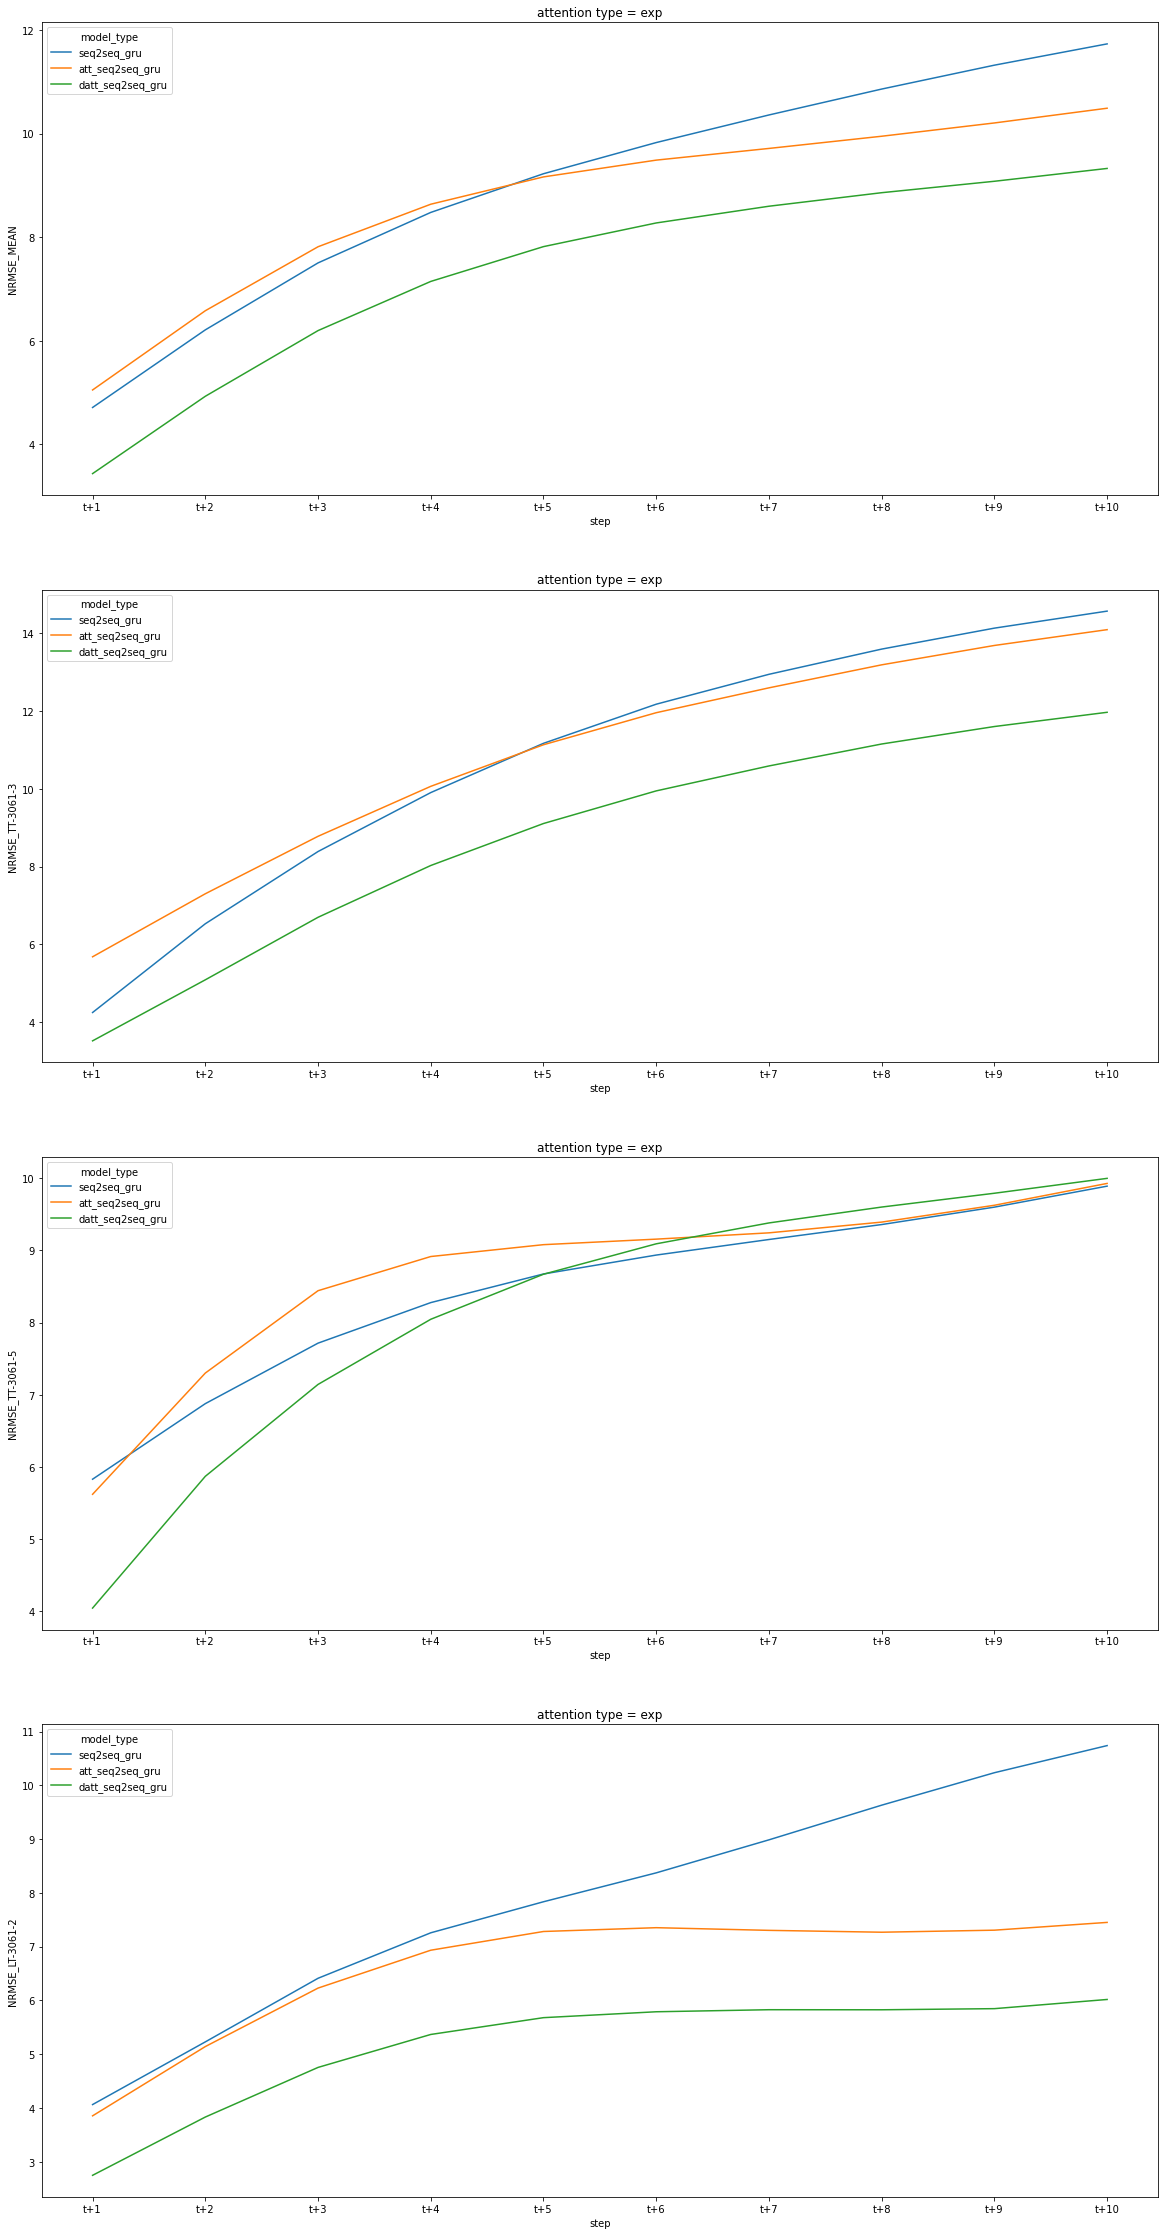

<Figure size 432x288 with 0 Axes>

In [15]:
data = result_reshape

plot_var = ['NRMSE_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2']

print("R2 results")
plt.figure(figsize=(future_size*2,len(plot_var)*10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']!='mean'].reset_index(drop=True)
    sns.lineplot(x='step', y=var, hue='model_type', markers=True, data=plot_data)
    
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention type = {att_type}")
    
figure_name = f'delta_comparison_{model_name}'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

# data = result_reshape

# plot_var = ['NRMSE_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2']
# att_type = 'linear'

# print("NRMSE results")
# plt.figure(figsize=(future_size*2,len(plot_var)*10))
# for i, var in enumerate(plot_var):
#     plt.subplot(len(plot_var), 1, i+1)
#     plot_data = data[data['att_type']==att_type]
#     sns.boxplot(x='step', y=var, hue='delta', data=plot_data, notch=False, showfliers = False)
#     # plt.ylim(-0.01, 0.3)
#     plt.title(f"attention type = {att_type}")
    
# figure_name = f'delta_comparison_linear_future_{future_size}_nrmse'
# if not exists(f'./figure/{figure_name}.png') or update:
#     savefile(_, './figure', figure_name, 'figure')
    
# plt.show()
# plt.tight_layout()

# Dual attention

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 40, 40),     5880        ['input_2[0][0]']                
                                 (None, 40)]                                                      
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 10, 40)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 40)       9840        ['repeat_vector_1[0][0]',  

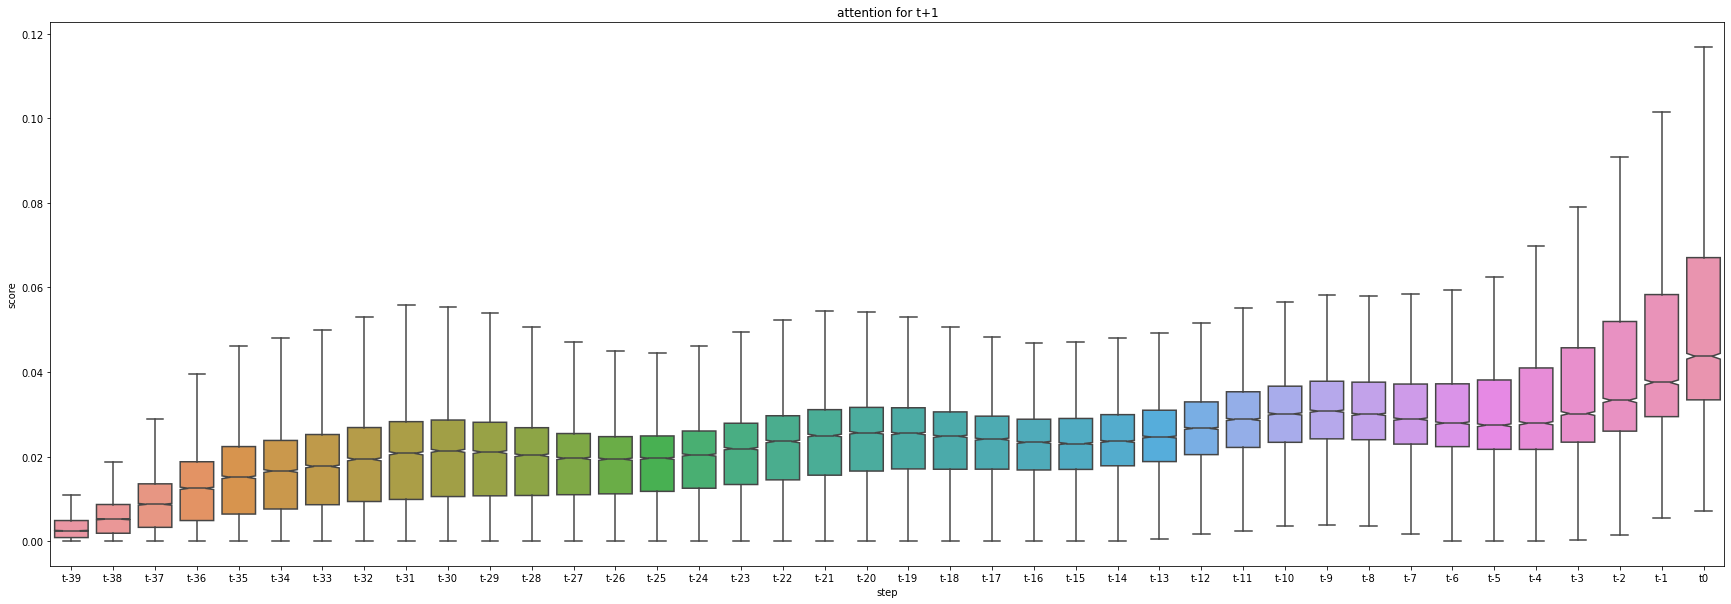

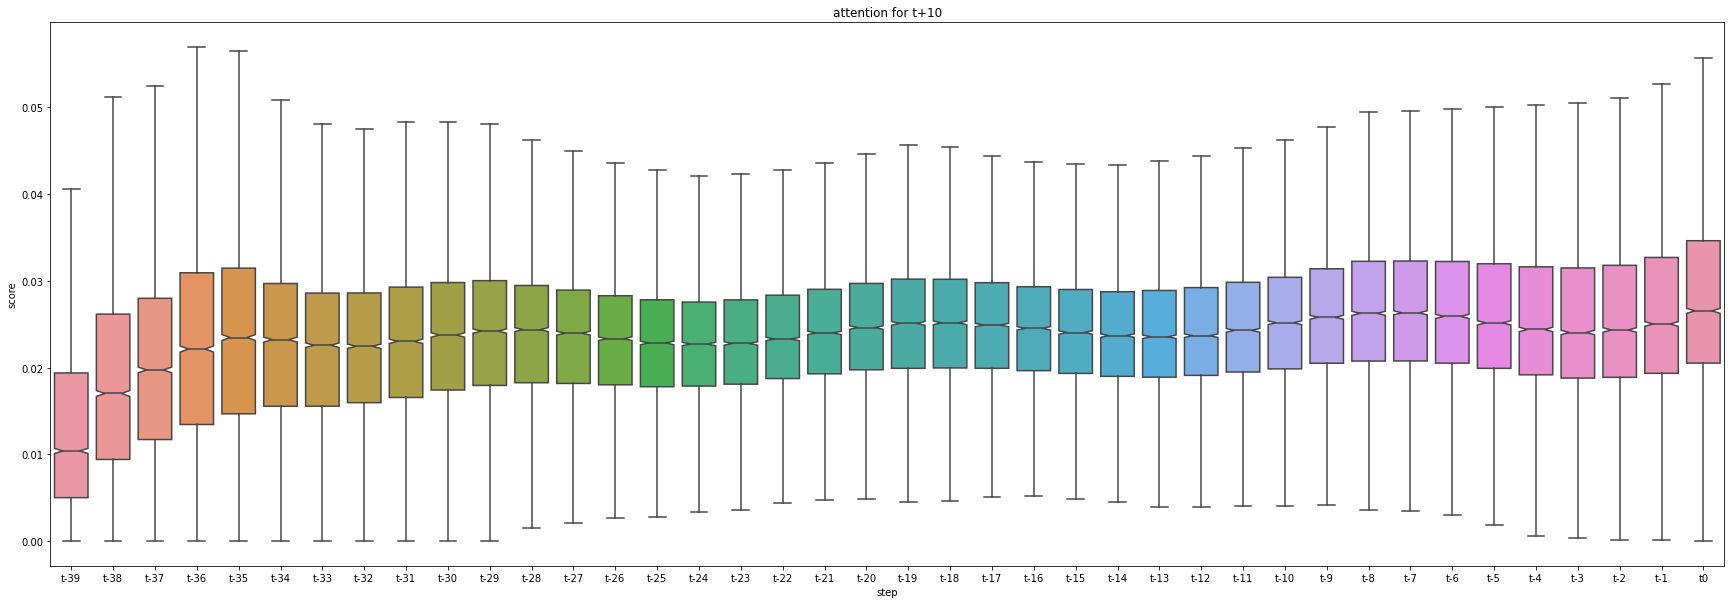

In [10]:
# RNN class 생성
DATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
DATT_seq2seq_GRU.scaling()
model_type = 'datt_seq2seq_gru'
DATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(DATT_seq2seq_GRU.model.summary())

model_num = 1
model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
DATT_seq2seq_GRU.model.load_weights(f"./model/{model_name}.h5")
attention = DATT_seq2seq_GRU.get_attention(DATT_seq2seq_GRU.history_test_sc)
plot_steps = [0,9]

for future_step in plot_steps:
    attention_step = pd.DataFrame(attention[:,future_step,:], columns=[f't{i-history_size+1}' for i in range(history_size)])

    for i in range(history_size):
        history_step = i-history_size+1
        if not i:
            attention_reshape = attention_step[[f't{history_step}']].copy()
            attention_reshape.columns = ['score']
            attention_reshape['step'] = f't{history_step}'
        else:
            temp = attention_step[[f't{history_step}']].copy()
            temp.columns = ['score']
            temp['step'] = f't{history_step}'        
            attention_reshape = pd.concat([attention_reshape, temp], axis=0)
        attention_reshape.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(30,10))
    sns.boxplot(x='step', y='score', data=attention_reshape, notch=True, showfliers = False)
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention for t+{future_step+1}")
    savefile(_, './figure', f'AttentionScore_{model_name}', 'figure')
    plt.show()